# Using docTR's standalone predictors

docTR’s `ocr_predictor` acts as a modular wrapper for its individual prediction models.
This notebook shows how to work with these models independently, which can be helpful if you don't need all the features of the `ocr_predictor`.
For instance, you might want to pair docTR's `detection_predictor` with a different recognition model.


In [2]:
# Install doctr
#!pip install python-doctr[torch,viz]
# From source
!pip install python-doctr[viz]@git+https://github.com/mindee/doctr.git

  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-n76tnn6g/python-doctr_8d950a975a8c47e888bcead0d21f610a
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-n76tnn6g/python-doctr_8d950a975a8c47e888bcead0d21f610a
  Resolved https://github.com/mindee/doctr.git to commit 07443a04502d3ef7bd4bf4f067305399a090fe29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Imports
import requests
import numpy as np
from matplotlib import pyplot as plt
import cv2

from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores

In [4]:
# Define sample image urls

# Image of receipt
receipt = requests.get("https://github.com/mindee/doctr/releases/download/v0.3.0/mock_receipt.jpeg").content
receipt_image = cv2.imdecode(np.frombuffer(receipt, np.uint8), cv2.IMREAD_COLOR)

# Image of a word crop
word_crop = requests.get("https://github.com/mindee/doctr/releases/download/v0.5.1/word-crop.png").content
word_crop_image = cv2.imdecode(np.frombuffer(word_crop, np.uint8), cv2.IMREAD_COLOR)

## Detection predictor

The detection predictor can be used to detect text in an image.

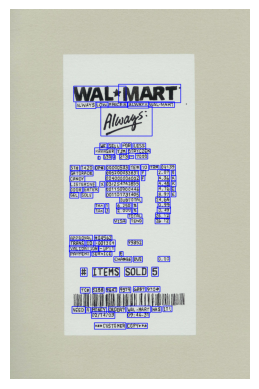

In [6]:
# Helper function to convert relative coordinates to absolute pixel values
def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
    h, w = img_shape
    if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
        (xmin, ymin), (xmax, ymax) = geom
        xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
        ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
        return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    else:  # For polygons, convert each point to absolute coordinates
        return [[int(point[0] * w), int(point[1] * h)] for point in geom]

# Define the detection predictor
import torch
det_predictor = detection_predictor(
    arch="db_resnet50",
    pretrained=True,
    assume_straight_pages=True,
    symmetric_pad=True,
    preserve_aspect_ratio=True,
    batch_size=1,
)
if torch.cuda.is_available():
    det_predictor.cuda().half()

# Define the postprocessing parameters (optional)
det_predictor.model.postprocessor.bin_thresh = 0.3
det_predictor.model.postprocessor.box_thresh = 0.1

# Load the document image
docs = DocumentFile.from_images([receipt])
results = det_predictor(docs)

for doc, res in zip(docs, results):
    img_shape = (doc.shape[0], doc.shape[1])
    # Detach the probability scores from the results
    detached_coords, prob_scores = detach_scores([res.get("words")])

    for i, coords in enumerate(detached_coords[0]):
        coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

        # Convert relative to absolute pixel coordinates
        points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))

        # Draw the bounding box on the image
        cv2.polylines(receipt_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

%matplotlib inline
plt.imshow(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

## Recognition predictor

The recognition predictor is used to recognize text from pre-cropped word images.

  0%|          | 0/95457349 [00:00<?, ?it/s]

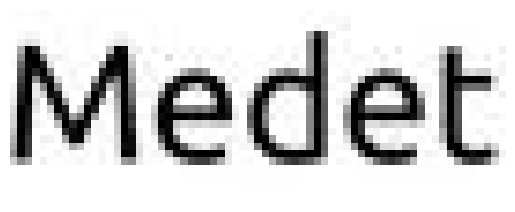

Recognized text: Medet 
with confidence: 1.00


In [7]:

# Load the word crop image
doc = DocumentFile.from_images([word_crop])
# Define the recognition predictor
rec_predictor = recognition_predictor(arch="parseq", pretrained=True, symmetric_pad=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = rec_predictor(doc)

%matplotlib inline
plt.imshow(cv2.cvtColor(word_crop_image, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
print(f"Recognized text: {result[0][0]} \nwith confidence: {result[0][1]:.2f}")



## Orientation predictors

The orientation predictors can detect the **overall** orientation of a document image or word crop.
They return the general orientation —[0, 90, 180, -90 (270)]— along with the corresponding confidence score.

In [8]:

docs = DocumentFile.from_images([receipt])
page_orient_predictor = page_orientation_predictor(pretrained=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = page_orient_predictor(docs)
print(f"general page orientation: {result[1][0]} with confidence: {result[2][0]:.2f}")

crop = DocumentFile.from_images([word_crop])
crop_orient_predictor = crop_orientation_predictor(pretrained=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = crop_orient_predictor(crop)
print(f"general crop orientation: {result[1][0]} with confidence: {result[2][0]:.2f}")

  0%|          | 0/6233146 [00:00<?, ?it/s]

general page orientation: 0 with confidence: 1.00


  0%|          | 0/6233146 [00:00<?, ?it/s]

general crop orientation: 0 with confidence: 1.00
